In [1]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in 

In [2]:
pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [3]:
from datasets import load_dataset

ds = load_dataset("SilpaCS/kneeosteoarthritis")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/8260 [00:00<?, ? examples/s]

In [4]:
ds['train'][1]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=224x224>,
 'label': 0}

In [5]:
image,_=ds['train'][1]['image'],ds['train'][1]['label']

In [6]:
import cv2
import PIL
import matplotlib.pyplot as plt

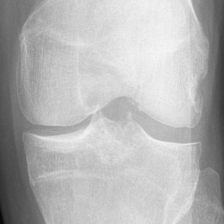

In [7]:
display(image)


In [8]:

from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-50")

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [9]:
pip install transformers datasets evaluate accelerate pillow torchvision scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.6 MB/s eta 0:00:00


In [10]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 8260
    })
})

In [11]:


ds = ds['train'].train_test_split(test_size=0.2)


In [12]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 6608
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1652
    })
})

In [13]:
ds["train"][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=224x224>,
 'label': 2}

In [14]:
labels = ds["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [15]:
from transformers import AutoImageProcessor

checkpoint = "microsoft/resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [16]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [17]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [18]:
ds = ds.with_transform(transforms)

In [19]:
import evaluate

accuracy = evaluate.load("accuracy")

In [20]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [28]:
from transformers import DefaultDataCollator
from transformers import TrainingArguments

from transformers import Trainer

data_collator = DefaultDataCollator()

In [29]:
model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([5, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
training_args = TrainingArguments(
    output_dir="my__model",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-3,
    per_device_train_batch_size=64,
    gradient_accumulation_steps=1,
    per_device_eval_batch_size=64,
    num_train_epochs=1,
    warmup_ratio=0.1,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    fp16=True,
)

In [32]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [33]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.366500,1.343873,0.441889


TrainOutput(global_step=104, training_loss=1.6850271408374493, metrics={'train_runtime': 1043.7355, 'train_samples_per_second': 6.331, 'train_steps_per_second': 0.1, 'total_flos': 1.4036023197174989e+17, 'train_loss': 1.6850271408374493, 'epoch': 1.0})

In [34]:
trainer.push_to_hub()


CommitInfo(commit_url='https://huggingface.co/sherylshiya/my__model/commit/00e61df3a4b0edbdf24e54cbf9bc0611c78ae723', commit_message='End of training', commit_description='', oid='00e61df3a4b0edbdf24e54cbf9bc0611c78ae723', pr_url=None, pr_revision=None, pr_num=None)

In [50]:

image = ds["test"][0]


In [55]:
image

{'label': 0,
 'pixel_values': tensor([[[-0.4397, -0.4226, -0.4397,  ..., -0.1828, -0.1828, -0.1828],
          [-0.4568, -0.4226, -0.4226,  ..., -0.1999, -0.2171, -0.2342],
          [-0.4568, -0.4397, -0.4054,  ..., -0.1999, -0.2171, -0.2513],
          ...,
          [-0.0116,  0.0398,  0.0056,  ..., -0.6794, -0.6452, -0.6794],
          [-0.0116,  0.0056, -0.0287,  ..., -0.6452, -0.6452, -0.6965],
          [-0.0458, -0.0629, -0.0629,  ..., -0.6623, -0.6794, -0.6965]],
 
         [[-0.3200, -0.3025, -0.3200,  ..., -0.0574, -0.0574, -0.0574],
          [-0.3375, -0.3025, -0.3025,  ..., -0.0749, -0.0924, -0.1099],
          [-0.3375, -0.3200, -0.2850,  ..., -0.0749, -0.0924, -0.1275],
          ...,
          [ 0.1176,  0.1702,  0.1352,  ..., -0.5651, -0.5301, -0.5651],
          [ 0.1176,  0.1352,  0.1001,  ..., -0.5301, -0.5301, -0.5826],
          [ 0.0826,  0.0651,  0.0651,  ..., -0.5476, -0.5651, -0.5826]],
 
         [[-0.0964, -0.0790, -0.0964,  ...,  0.1651,  0.1651,  0.1651],

In [53]:
img=image["pixel_values"]

array([[177, 172, 181, ...,  48,  44,  44],
       [181, 177, 181, ...,  44,  44,  40],
       [177, 177, 181, ...,  40,  40,  35],
       ...,
       [ 76,  85,  89, ..., 181, 172, 172],
       [ 89,  89,  94, ..., 172, 177, 172],
       [ 94,  98,  94, ..., 172, 172, 164]], dtype=uint8)
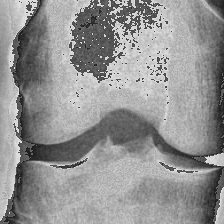

In [46]:
display(image)

In [56]:
from PIL import Image
import numpy as np

pixel_values = image['pixel_values']

image_array = pixel_values.numpy()

# Rescale pixel
image_array = (image_array + 1) * 127.5
image_array = image_array.astype(np.uint8)


image_array = image_array.transpose(1, 2, 0)

image = Image.fromarray(image_array)

In [57]:
from transformers import pipeline

classifier = pipeline("image-classification", model="my__model")
classifier(image)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': '1', 'score': 1.0},
 {'label': '0', 'score': 8.705698431673573e-39},
 {'label': '2', 'score': 0.0},
 {'label': '3', 'score': 0.0},
 {'label': '4', 'score': 0.0}]